In [1]:
'''
LoRA，即低秩适应，是一种仅调整模型权重参数的一小部分，就可以让预训练模型更好地适应特定（通常较小）数据集的技术。
“低秩”指的是将模型调整限制在总权重参数空间的一个较小维度子空间的数学概念，这有效地捕获了训练期间权重参数变化的最具影响力的方向。
LoRA 的好处就是，它能让预训练模型快速适应新的任务，而且只需要学习和调整很少的“小工具”，这样就更高效、更省资源。

LoRA 的权重是独立于原始模型权重的：
1. 原始的“超级大脑”保持不变
2. “插件”很小，训练起来更快更省资源
3. 可以灵活地切换任务
4. 部署和存储更方便
'''

'''
如何将文本消息分类为垃圾短信或正常短信

微调语言模型最常见的方法是指令微调和分类微调
指令微调：通过在一组任务上使用特定指令训练模型，用以提升模型对自然语言提示中任务描述的理解和执行能力
分类微调：模型被训练用来识别特定的一组类别标签
'''

'''
1： 准备数据集
'''
from pathlib import Path

data_file_path = "D:\codes\llm-evaluation\ch_6\sms_spam_collection\SMSSpamCollection.tsv"


#A 下载数据集
#B 解压数据集
#C 为解压的数据集文件设置.tsv文件扩展名
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df  #A

#A 在 Jupyter Notebook 中可以直接渲染数据，或者用 print(df) 命令显示数据内容
# 统计分类情况
print(df["Label"].value_counts())
'''
我们选择对数据集进行下采样，每个类别保留 747 个样本，为了更快的进行微调

'''


# Creating a balanced dataset
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]  #A
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)  #B
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])  #C
    return balanced_df


balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

#A 统计垃圾短信的实例数量
#B 随机抽取正常邮件实例，使其数量与垃圾短信实例相同。
#C 将正常短信子集与垃圾短信合并

# 将字符串类别标签 "ham" 和 "spam" 分别转换为整数类别标签 0 和 1
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

'''
创建一个random_split函数，将数据集划分为三部分：70%用于训练，10%用于验证，20%用于测试
'''


# Splitting the dataset
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)  #A

    train_end = int(len(df) * train_frac)  #B
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]  #C
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df


train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)  #D

#A 将整个 DataFrame 随机打乱
#B 计算数据分割的索引
#C 分割 DataFrame
#D 测试集默认大小为 0.2（即剩余部分）

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)
'''
2： 创建数据加载器

为了像第 2 章中的文本块那样对这些消息进行批处理，我们有两种处理方式：

将所有消息截断至数据集或批次中最短消息的长度。
将所有消息填充到数据集或批次中最长消息的长度。

方案一的计算成本较低，但如果较短的消息远小于平均长度或最长消息长度，可能会导致显著的信息损失，从而降低模型的性能。因此，我们选择方案二，以完整保留所有消息的内容。
'''
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

# 定义SpamDataset类：识别训练数据集中最长的序列，对文本消息进行编码，并确保通过填充 token 将其他序列补齐到与最长序列相同的长度
# Setting up a Pytorch Dataset class
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [  #A
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            self.encoded_texts = [  #B
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        self.encoded_texts = [  #C
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


#A 对文本进行预分词
#B 若序列超过最大长度则进行截断
#C 将序列填充至最长序列长度
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
# Creating PyTorch data loaders
# 创建训练集、验证集和测试集的数据加载器，以批量大小为 8 加载文本消息及其标签
from torch.utils.data import DataLoader

num_workers = 0  #A
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

#A 此设置可确保与大多数计算机兼容

# 为了确保数据加载器正常工作并确实返回了预期大小的批次数据，可以遍历训练集数据加载器，并打印最后一个批次的张量维度

for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")
'''
3: 使用预训练权重初始化模型
'''

CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,  # Dropout rate
    "qkv_bias": True  # Query-key-value bias
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

Label
ham     4825
spam     747
Name: count, dtype: int64
Label
ham     747
spam    747
Name: count, dtype: int64
[50256]
120
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
130 training batches
19 validation batches
38 test batches


In [2]:
# Loading a pretrained GPT model
from ch_5.gpt_download import download_and_load_gpt2
from ch_4.build_gpt import GPTModel, generate_text_simple
from ch_5.ch5 import load_weights_into_gpt, text_to_token_ids, token_ids_to_text

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()


Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren
torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix
Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([3.9108e-05, 5.6776e-05, 4.7559e-06])
tensor([ -9.5042, -10.3796, -11.3677, -10.1492,  -9.7764, -12.2561])
tensor(-10.5722)
tensor(10.5722)
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
tensor(10.5722)
Characters: 20479
Tokens: 5145
Training loss: 10.987583584255642
Validation loss: 10.981106758117676
Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren Mortgage TT remember gard ACTIONSussedOND Land Engeleddedemate breaths proxies GalaxyForm
File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
Fil

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [3]:

# 将模型权重加载到GPTModel后，我们使用前面章节的文本生成工具函数，确保模型能够生成连贯的文本
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))
# 看看这个模型是否能通过给它提供指令来对垃圾短信进行分类
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))
'''
4： 添加分类头

为分类任务的微调做准备：
输出层将隐层表示映射到50,257个词汇的词汇表，而我们用一个较小的输出层将其映射到两个类别：0（‘非垃圾短信’）和1（‘垃圾短信’）
'''
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Every effort moves you forward.

The first step is to understand the importance of your work
Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [4]:
# 为了计算分类准确率，我们对数据集中的所有样本进行 argmax 预测，并通过定义一个 calc_accuracy_loader 函数来计算预测正确的比例
# Calculating the classification accuracy
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]                   #A
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

#A 最后一个输出 token 的 logits 值

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 可以使用这个函数来估算多个数据集上的分类准确率，为提高效率，这里基于 10 个批次的结果进行估算
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [6]:
'''
alpha用作低秩适应输出的缩放因子。它主要决定了来自适应层的输出对原始层输出的影响程度。这可以看作是一种调节低秩适应对层输出影响的方式
'''

# Implementing a LoRA layer

import math

class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))      #A
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x


#A 使用与 PyTorch 中线性层相同的初始化方式
'''
秩 (Rank):

决定了 LoRA “小工具” 的大小: 还记得之前我们把 LoRA 比作给预训练模型添加一些专门的“小工具”吗？这里的“秩”就决定了这些“小工具”（更具体地说是矩阵 A 和 B）的内部大小。
你可以想象成，秩越大，“小工具”就越复杂，包含的信息就越多。
影响额外学习的参数数量: 秩越大，LoRA 引入的需要学习的额外参数就越多。反之，秩越小，需要学习的参数就越少。
平衡模型的学习能力和效率:
秩高一点: 模型可以学习到更复杂、更细致的针对特定任务的调整，性能可能会更好。但是，需要学习的参数也更多，训练起来可能更慢，更耗费资源。
秩低一点: 模型学习的参数更少，训练速度更快，更节省资源。但是，如果秩太低，模型可能没有足够的“能力”来学习到足够好的调整，导致性能不够理想。
就像给自行车加辅助轮: 秩就像辅助轮的大小。大的辅助轮（高秩）更容易保持平衡，但可能不够灵活。小的辅助轮（低秩）更灵活，但可能需要更高的骑行技巧。你需要找到一个合适的平衡点。
Alpha:

LoRA “小工具” 输出的音量调节器: Alpha 可以看作是一个调节 LoRA 带来的改变有多大的“音量旋钮”。它是一个数字，用来乘以 LoRA “小工具” 的输出结果。
控制适应层对原始层的影响: Alpha 的大小决定了 LoRA 学习到的调整对原始模型输出的影响程度。
Alpha 大一点: LoRA 带来的改变会更明显，模型会更倾向于学习新的任务。
Alpha 小一点: LoRA 带来的改变会更微妙，模型更多地还是依赖于它原本学到的知识，只是做一些微小的调整。
就像调味品: Alpha 就像你做菜时放的盐。盐放多了（Alpha 大了），菜的味道变化就大；盐放少了（Alpha 小了），菜的味道变化就小。你需要根据你的口味来调整。
总结一下：

秩 (Rank) 决定了 LoRA 可以学习多少新的信息，以及需要多少额外的参数。
Alpha 决定了 LoRA 学习到的信息对最终结果的影响有多大。
这两个参数都需要根据具体的任务和模型进行调整，以达到最佳的性能和效率。
'''



'\n秩 (Rank):\n\n决定了 LoRA “小工具” 的大小: 还记得之前我们把 LoRA 比作给预训练模型添加一些专门的“小工具”吗？这里的“秩”就决定了这些“小工具”（更具体地说是矩阵 A 和 B）的内部大小。你可以想象成，秩越大，“小工具”就越复杂，包含的信息就越多。\n影响额外学习的参数数量: 秩越大，LoRA 引入的需要学习的额外参数就越多。反之，秩越小，需要学习的参数就越少。\n平衡模型的学习能力和效率:\n秩高一点: 模型可以学习到更复杂、更细致的针对特定任务的调整，性能可能会更好。但是，需要学习的参数也更多，训练起来可能更慢，更耗费资源。\n秩低一点: 模型学习的参数更少，训练速度更快，更节省资源。但是，如果秩太低，模型可能没有足够的“能力”来学习到足够好的调整，导致性能不够理想。\n就像给自行车加辅助轮: 秩就像辅助轮的大小。大的辅助轮（高秩）更容易保持平衡，但可能不够灵活。小的辅助轮（低秩）更灵活，但可能需要更高的骑行技巧。你需要找到一个合适的平衡点。\nAlpha:\n\nLoRA “小工具” 输出的音量调节器: Alpha 可以看作是一个调节 LoRA 带来的改变有多大的“音量旋钮”。它是一个数字，用来乘以 LoRA “小工具” 的输出结果。\n控制适应层对原始层的影响: Alpha 的大小决定了 LoRA 学习到的调整对原始模型输出的影响程度。\nAlpha 大一点: LoRA 带来的改变会更明显，模型会更倾向于学习新的任务。\nAlpha 小一点: LoRA 带来的改变会更微妙，模型更多地还是依赖于它原本学到的知识，只是做一些微小的调整。\n就像调味品: Alpha 就像你做菜时放的盐。盐放多了（Alpha 大了），菜的味道变化就大；盐放少了（Alpha 小了），菜的味道变化就小。你需要根据你的口味来调整。\n总结一下：\n\n秩 (Rank) 决定了 LoRA 可以学习多少新的信息，以及需要多少额外的参数。\nAlpha 决定了 LoRA 学习到的信息对最终结果的影响有多大。\n这两个参数都需要根据具体的任务和模型进行调整，以达到最佳的性能和效率。\n'

In [7]:
'''
现在创建一个 LinearWithLoRA 层。该层利用了之前实现的 LoRALayer，旨在替换神经网络中现有的线性层，例如 GPTModel 中的自注意力模块或前馈模块
'''
# A LinearWithLora layer to replace Linear layers

class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
   		 return self.linear(x) + self.lora(x)

In [8]:
# 引入了一个 replace_linear_with_lora 函数。该函数会将模型中所有现有的线性层替换为新创建的 LinearWithLoRA 层

def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):               #A
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:                                                 #B
            replace_linear_with_lora(module, rank, alpha)


#A 将线性层替换为 LinearWithLoRA
#B 将相同的函数递归地应用于子模块

In [9]:
# 使用上述函数进行层升级前，需要冻结原始模型的参数

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in model.parameters():
	param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 124,441,346
Total trainable parameters after: 0


In [10]:
replace_linear_with_lora(model, rank=16, alpha=16)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

'''
使用 LoRA 后，可训练参数的数量减少了近 50 倍。秩和 alpha 一般都默认设置为 16 ，但通常也会增加秩的大小，这从而增加可训练参数的数量。Alpha 通常选择为秩的一半、两倍或相等
'''

Total trainable LoRA parameters: 2,666,528


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=768, out_featu

In [12]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

'''
与之前的初始值进行比较，我们会发现它们是相同的。这是因为我们将 LoRA 矩阵 B 初始化为零。
因此，矩阵 AB 的乘积得到一个零矩阵。这确保了在开始微调之前，该乘法不会改变原始权重，因为加零不会改变它们
'''

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [13]:
'''
定义损失函数，以便在训练过程中对其进行优化：最大化模型的垃圾短信分类准确率，因此代码输出应为正确的类别标签：0 表示正常短信，1 表示垃圾短信
'''
# 与之前的区别是：我们只优化最后一个 token（model(input_batch)[:, -1, :]），而不是整个序列中的所有 token（model(input_batch)）
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :] # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

# Calculating the classification loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:                                      #A
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


'''
使用监督数据对模型进行微调
'''

# 与之前的唯一区别：现在记录的是训练样本数量（examples_seen），而不是 token 数量；并且在每个 epoch 后计算准确率，而不再打印示例文本
# Finetuning the model to classify spam
def train_classifier_simple(model, train_loader, val_loader, optimizer, device,
num_epochs, eval_freq, eval_iter, tokenizer):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()                                      #A

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()                          #B
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()                                #C
            optimizer.step()                               #D
            examples_seen += input_batch.shape[0]          #E
            global_step += 1


            if global_step % eval_freq == 0:               #F
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        train_accuracy = calc_accuracy_loader(             #G
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


#A 设置模型为训练模式
#B 重置上一批次的损失梯度
#C 计算损失梯度
#D 使用损失梯度更新模型权重
#E 更改逻辑：跟踪样本数量而非 token 数量
#F 可选评估步骤
#G 每个 epoch 后计算准确率

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [14]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.820, Val loss 3.462
Ep 1 (Step 000050): Train loss 0.396, Val loss 0.364
Ep 1 (Step 000100): Train loss 0.111, Val loss 0.229
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 2 (Step 000150): Train loss 0.135, Val loss 0.073
Ep 2 (Step 000200): Train loss 0.010, Val loss 0.044
Ep 2 (Step 000250): Train loss 0.027, Val loss 0.179
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.224, Val loss 0.050
Ep 3 (Step 000350): Train loss 0.045, Val loss 0.081
Training accuracy: 100.00% | Validation accuracy: 92.50%
Ep 4 (Step 000400): Train loss 0.014, Val loss 0.059
Ep 4 (Step 000450): Train loss 0.012, Val loss 0.103
Ep 4 (Step 000500): Train loss 0.001, Val loss 0.019
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.001, Val loss 0.049
Ep 5 (Step 000600): Train loss 0.009, Val loss 0.080
Training accuracy: 100.00% | Validation accuracy: 95.00%
Training completed in 22.63

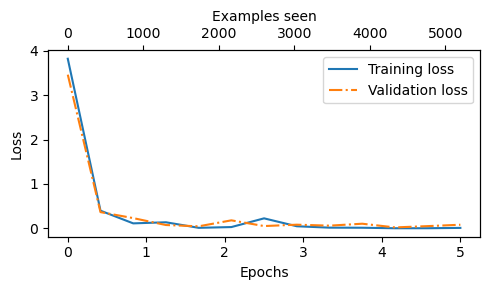

In [15]:
# Plotting the classification loss
import matplotlib.pyplot as plt
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")    #A
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()                                                 #B
    ax2.plot(examples_seen, train_values, alpha=0) # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()                                                #C
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


#A 绘制训练轮次与训练和验证损失的变化图
#B 创建一个新的 x 轴，用于显示已处理样本数
#C 调整布局以留出空间

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [16]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

'''
结果表明存在轻微的过拟合，因为与训练集相比，该模型在新数据上的泛化能力稍差。
总的来说，考虑到我们只微调了相对较少数量的模型权重（270 万个 LoRA 权重，而不是原来的 1.24 亿个模型权重），结果已经不错了。
'''

Training accuracy: 99.62%
Validation accuracy: 96.64%
Test accuracy: 97.67%
